<a href="https://colab.research.google.com/github/TatKhachatryan/UBA/blob/main/anomaly_detection_UBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

!pip install pyod
from pyod.models.lof import LOF
from pyod.models.knn import KNN

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

     |████████████████████████████████| 114 kB 4.1 MB/s 
  Created wheel for pyod: filename=pyod-0.9.8-py3-none-any.whl size=136775 sha256=88a8569f51446f9ee939793d5af218b529e2b94072e68fe91a232f50f7eb1f47
  Stored in directory: /root/.cache/pip/wheels/ba/8f/95/6cb376aec9fae09d9b1622d1662c902b522deb353cb80836a6
Successfully built pyod


## **Data Processing**

In [16]:

df_20 = pd.read_csv('/content/drive/MyDrive/UBA Project/csv files/logs_2020.csv')

In [17]:
df_20.rename(columns={'at': 'date'}, inplace=True)
df_20['account'] = df_20['account'].astype('str')

In [18]:
pivot_20 = df_20.groupby(by=["date", "account", "aim"]).size().unstack(fill_value=0).reset_index()

New dataframe with **top 10 actions**:<br>
'open_task', 'open_perform_action', 'perform_action', 'download_task_file', 'attach_task_file','create_task', 'remove_inform',  'apply_label','open_role','download_task_files'

In [19]:
df = pivot_20[['date', 'account', 'open_task', 'open_perform_action', 'perform_action', 'download_task_file', 'attach_task_file','create_task', 'remove_inform',  'apply_label','open_role','download_task_files']]
df['date']= pd.to_datetime(df['date'])

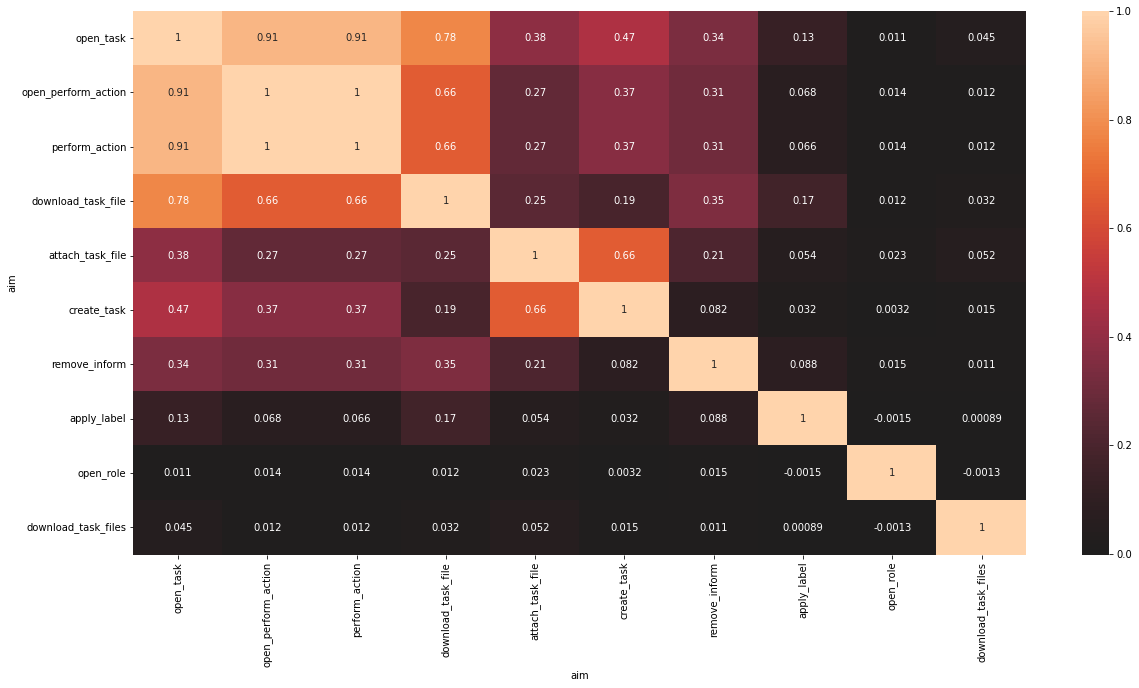

In [20]:
# correlation between features
corr = df.corr()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, center=0, annot=True)

I'll find anomalies in a total data, but before jumping to that I'd like to make a k-means clustering and find anomalies in clusters.

**Clustering with k-means**

In [21]:
# model creating
X = df.drop(['date'], axis=1)
model = KMeans(n_clusters=4, init='k-means++', random_state=42)
model.fit(X)

preds = model.predict(X)

# copy of our data
account_kmeans = X.copy()
account_kmeans['clusters'] = preds
account_kmeans['clusters'].value_counts()

1    39409
0    30980
3    23582
2     1636
Name: clusters, dtype: int64

In [22]:
# we got 4 clusters

cluster0 = account_kmeans.loc[account_kmeans['clusters']==0]
cluster1 = account_kmeans.loc[account_kmeans['clusters']==1]
cluster2 = account_kmeans.loc[account_kmeans['clusters']==2]
cluster3 = account_kmeans.loc[account_kmeans['clusters']==3]

In [23]:
cluster2.describe()

aim,open_task,open_perform_action,perform_action,download_task_file,attach_task_file,create_task,remove_inform,apply_label,open_role,download_task_files,clusters
count,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.0
mean,553.734108,371.763447,366.965770,163.325183,17.869193,47.668093,8.482885,0.705379,0.017726,0.083130,2.0
std,232.104125,249.738519,246.022383,113.850363,38.052129,75.305871,16.775118,5.421781,0.201654,0.584559,0.0
min,247.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,414.000000,224.000000,220.000000,78.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
50%,507.000000,305.000000,301.000000,146.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2.0
75%,631.000000,457.250000,456.000000,226.000000,18.000000,86.000000,7.000000,0.000000,0.000000,0.000000,2.0
max,2415.000000,2411.000000,2364.000000,896.000000,710.000000,712.000000,162.000000,86.000000,5.000000,13.000000,2.0


# **Modeling**

In [24]:
to_model_columns=df.columns[1:]

### **KNN**

In [25]:
knn_model = KNN(contamination=0.12).fit(df[to_model_columns])
lbls = knn_model.labels_
df['anoms_KNN'] = lbls 

### **Local Outlier Factor**

In [26]:
LOF_model = LOF(contamination=0.12).fit(df[to_model_columns])

lof_lbls = LOF_model.labels_
df['anoms_LOF'] = lof_lbls

### **Isolation Forest**

In [27]:
iForest_model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

iForest_model.fit(df[to_model_columns])

pred = iForest_model.predict(df[to_model_columns])
df['anoms_iForest']= pred

### Comparing 3 models:

In [28]:
print('Anomaly labels made by Local Outlier Factor: ')
df['anoms_LOF'].value_counts()

Anomaly labels made by Local Outlier Factor: 


0    84134
1    11473
Name: anoms_LOF, dtype: int64

In [29]:
print('Anomaly labels made by KNN: ')
df['anoms_KNN'].value_counts()

Anomaly labels made by KNN: 


0    84138
1    11469
Name: anoms_KNN, dtype: int64

In [30]:
print('Anomaly labels made by Isolation Forest: ')
df['anoms_iForest'].value_counts()

Anomaly labels made by Isolation Forest: 


 1    84134
-1    11473
Name: anoms_iForest, dtype: int64

As we can see Local Outlier Factor and Isolation Forest have the exact same results. Anomalies detected by KNN are pretty close to LOF and KNN results.

From now on, I'll create a function which takes an action name (aim) as an argument and returns a new dataframe with all the anomalies in it.

In [31]:
normal_behavior = df.loc[df['anoms_LOF']==0]

In [32]:
# defining normal behavior's maximum value for each of 10 aims

# 1. open_task
open_task_allowed_max_value = normal_behavior.describe()['open_task']['max']
# 2. open_perform_action
open_perform_action_allowed_max_value = normal_behavior.describe()['open_perform_action']['max']
# 3. perform_action
perform_action_allowed_max_value = normal_behavior.describe()['perform_action']['max']
# 4. download_task_file
download_task_file_allowed_max_value = normal_behavior.describe()['download_task_file']['max']
# 5. attach_task_file
attach_task_file_allowed_max_value = normal_behavior.describe()['attach_task_file']['max']
# 6. create_task
create_task_allowed_max_value = normal_behavior.describe()['create_task']['max']
# 7. remove_inform
remove_inform_allowed_max_value = normal_behavior.describe()['remove_inform']['max']
# 8. apply_label
apply_label_allowed_max_value = normal_behavior.describe()['apply_label']['max']
# 9. open_role
open_role_allowed_max_value = normal_behavior.describe()['open_role']['max']
# 10. download_task_files
download_task_files_allowed_max_value = normal_behavior.describe()['download_task_files']['max']

In [33]:
# the same function which takes the aim as an argument and returns a dataframe with all the anomalies in it

def anomaly_df(action_name):
  date = []
  acc = []

  used_value = []
  allowed_value = normal_behavior.describe()[action_name]['max']

  for dt in df.loc[df[action_name]>normal_behavior.describe()[action_name]['max']]['date']:
    day = str(dt)
    date.append(day[:10])

  for ac in df.loc[df[action_name]>normal_behavior.describe()[action_name]['max']]['account']:
    account = str(ac)
    acc.append(account)

  for val in df.loc[df[action_name]>normal_behavior.describe()[action_name]['max']][action_name]:
    used_value.append(val)

  action = []
  acc_numb = len(acc)
  action_name = action_name
  action.extend([action_name] * acc_numb)

  anomalies_df = pd.DataFrame({'Date': date,
                                    'Account': acc,
                                    'Action Name': action,
                                    'Used Value': used_value,
                                    'Allowed Maximum Value': allowed_value})
  return anomalies_df

In [34]:
# create dataframes with anomalies in it for all 10 aims

anomalies_open_task = anomaly_df('open_task')
anomalies_open_perform_action = anomaly_df('open_perform_action')
anomalies_perform_action = anomaly_df('perform_action')
anomalies_download_task_file = anomaly_df('download_task_file')
anomalies_attach_task_file = anomaly_df('attach_task_file')
anomalies_create_task = anomaly_df('create_task')
anomalies_remove_inform = anomaly_df('remove_inform')
anomalies_apply_label = anomaly_df('apply_label')
anomalies_open_role = anomaly_df('open_role')
anomalies_download_task_files = anomaly_df('download_task_files')

In [35]:
# the only way I could join all these 10 dataframes in 1 dataframe (which I called final_df)

result = pd.concat([anomalies_open_task, anomalies_open_perform_action], axis=0, ignore_index=True)
result1 = pd.concat([result, anomalies_perform_action], axis=0, ignore_index=True)
result2 = pd.concat([result1, anomalies_download_task_file], axis=0, ignore_index=True)
result3 = pd.concat([result2, anomalies_attach_task_file], axis=0, ignore_index=True)
result4 = pd.concat([result3, anomalies_create_task], axis=0, ignore_index=True)
result5 = pd.concat([result4, anomalies_remove_inform], axis=0, ignore_index=True)
result6 = pd.concat([result5, anomalies_apply_label], axis=0, ignore_index=True)
result7 = pd.concat([result6, anomalies_open_role], axis=0, ignore_index=True)


final_df = pd.concat([result7, anomalies_download_task_files], axis=0, ignore_index=True)

In [36]:
final_df = final_df.sort_values(by='Date')
final_df.reset_index(inplace=True)

In [37]:
final_df.drop(['index'], axis=1, inplace=True)

In [47]:
# final_df has 5 columns: Date, Account, Action Name, Used Value, Allowed Maximum Value
final_df

,Date,Account,Action Name,Used Value,Allowed Maximum Value
0,2020-02-19,321,remove_inform,191,130.0
1,2020-03-03,402,download_task_file,714,490.0
2,2020-03-31,402,download_task_file,508,490.0
3,2020-04-17,402,download_task_file,837,490.0
4,2020-04-19,371,attach_task_file,220,194.0
5,2020-04-20,371,attach_task_file,231,194.0
6,2020-04-21,365,remove_inform,154,130.0
7,2020-04-24,799,attach_task_file,240,194.0
8,2020-04-28,3,open_role,146,20.0
9,2020-04-28,428,open_task,2398,2319.0


## **Additional:**

## IsolationForest with clusters

In [39]:
# modeling for cluster0
to_model_columns0=cluster0.columns[1:-2]

clf0=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

clf0.fit(cluster0[to_model_columns0])

pred0= clf0.predict(cluster0[to_model_columns0])
cluster0['anomaly']= pred0
anomal_behavior0 = cluster0.loc[cluster0['anomaly']==-1]
normal_behavior0 = cluster0.loc[cluster0['anomaly']==1]

In [40]:
# modeling for cluster1
to_model_columns0=cluster1.columns[1:-2]

clf1=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

clf1.fit(cluster1[to_model_columns0])

pred1= clf1.predict(cluster1[to_model_columns0])
cluster1['anomaly']= pred1
anomal_behavior1 = cluster1.loc[cluster1['anomaly']==-1]
normal_behavior1 = cluster1.loc[cluster1['anomaly']==1]

In [41]:
# modeling for cluster2
to_model_columns0=cluster2.columns[1:-2]

clf2=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

clf2.fit(cluster1[to_model_columns0])

pred2= clf2.predict(cluster2[to_model_columns0])
cluster2['anomaly']= pred2
anomal_behavior2 = cluster2.loc[cluster2['anomaly']==-1]
normal_behavior2 = cluster2.loc[cluster2['anomaly']==1]

In [42]:
# modeling for cluster3
to_model_columns0=cluster3.columns[1:-2]

clf3=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

clf3.fit(cluster3[to_model_columns0])

pred3= clf3.predict(cluster3[to_model_columns0])
cluster3['anomaly']= pred3
anomal_behavior3 = cluster3.loc[cluster3['anomaly']==-1]
normal_behavior3 = cluster3.loc[cluster3['anomaly']==1]

In [43]:
normal_behavior3.describe()

aim,open_task,open_perform_action,perform_action,download_task_file,attach_task_file,create_task,remove_inform,apply_label,open_role,download_task_files,clusters,anomaly
count,20752.000000,20752.000000,20752.000000,20752.000000,20752.000000,20752.000000,20752.000000,20752.000000,20752.0,20752.000000,20752.0,20752.0
mean,22.109676,5.896299,5.711594,9.574499,1.447138,0.667695,0.410033,0.018504,0.0,0.071559,3.0,1.0
std,30.012913,11.475840,11.191825,15.382851,3.017371,1.584867,1.166080,0.175467,0.0,0.872994,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.0,1.0
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.0,1.0
50%,9.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.0,1.0
75%,30.000000,6.000000,6.000000,12.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,3.0,1.0
max,296.000000,94.000000,91.000000,188.000000,37.000000,22.000000,11.000000,3.000000,0.0,34.000000,3.0,1.0


In [44]:
anomal_behavior3.describe()

aim,open_task,open_perform_action,perform_action,download_task_file,attach_task_file,create_task,remove_inform,apply_label,open_role,download_task_files,clusters,anomaly
count,2830.000000,2830.000000,2830.000000,2830.000000,2830.000000,2830.000000,2830.000000,2830.000000,2830.0,2830.000000,2830.0,2830.0
mean,144.767138,61.549470,61.050883,65.996820,14.448763,11.719081,5.244170,1.069611,0.0,0.253710,3.0,-1.0
std,79.095504,49.609769,49.520260,49.656149,17.512184,18.999727,8.319323,3.158659,0.0,1.454122,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.0,-1.0
25%,88.000000,25.000000,25.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.0,-1.0
50%,133.500000,46.000000,45.000000,57.000000,7.000000,4.000000,3.000000,0.000000,0.0,0.000000,3.0,-1.0
75%,187.000000,88.000000,87.000000,92.000000,24.000000,16.000000,7.000000,0.000000,0.0,0.000000,3.0,-1.0
max,555.000000,253.000000,262.000000,588.000000,123.000000,149.000000,165.000000,42.000000,0.0,32.000000,3.0,-1.0
